<a href="https://colab.research.google.com/github/GabrielChuchuca/SIMULACION/blob/main/Deber1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install simpy

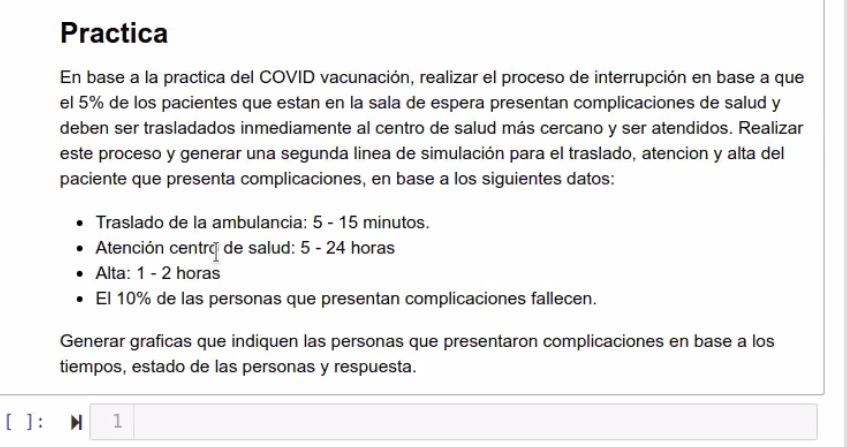

In [3]:
import simpy
import random
from random import choice
import matplotlib.pyplot as pp

%matplotlib inline

In [4]:
# Maximo de vacunas
MAX_VACUNAS = 9150
# Total de numero de puntos de vacunacion
JUNTAS = 28
PACIENTES = 9130
# Intervalo de tiempo en que llegan los pacientes
INTERVALO_LLEGADA = 5 
# Tiempo de simulación
TIEMPO_SIMULACION = 1000

tiempo_vacunacion={}

pri_dosis ={} #
seg_dosis = {} #

p_no_vacunado = []

n_vacunas_apli = 0 

#Fecha inicial 30 dias, y se suma 1 dia.
fecha_inicial =30

In [5]:
class Recinto(object):
    def __init__(self, environment, num_mesas, nombre_recinto):
        # Guardamos como variable el entorno de ejecucion
        self.env=environment
        # Creamos el recurso que representa las mesas o juntas 
        self.mesas = simpy.Resource(environment, num_mesas)
        self.nombre_recinto = nombre_recinto

    # Segun UNICEF las personas que no se beberian vacunar son las que presentan alergias a los componentes
    # de las vacunas y las que presenten sintomas de COVID-19
    # Para validar si un paciente tiene sintomas o no haremos 
    def verificacion_sintomas(self, paciente, tam_no_vacunados, n_per_sintomas):
        estado = choice(["con sintomas", "sin sintomas"])
        if tam_no_vacunados<=n_per_sintomas and estado == "con sintomas":
            p_no_vacunado.append(paciente)
        return estado

    #La persona se acerca y hace fila para recibir la vacunacion de la primera dosis
    def pri_dosis(self, paciente, sintomas):
        if sintomas == "sin sintomas":
            t_vacunacion = random.randint(5,10) # ◦	Realiza la vacunación en un tiempo aleatorio entre 5 a 10 minutos.
            yield self.env.timeout(t_vacunacion)
            print("El paciente ", paciente, " ha sido vacunado con la primera dosis.")
            print("La aplicacion de la segunda dosis es luego de 30 dias")
            
            pri_dosis[paciente] = t_vacunacion
        else:
            print("El paciente ",paciente," presenta sintomas de COVID-19, por lo que no puede ser vacunado.")
    
    # lA APLIACION DE ESTA DOSIS ES DESPUES DE 30 DIAS APLICADA LA PRIMERA DOSIS
    def seg_dosis(self, paciente, sintomas):
        if sintomas == "sin sintomas":
            t_vacunacion = random.randint(5,10)
            yield self.env.timeout(t_vacunacion)
            print("El paciente ",paciente, "ha sido vacunado con la segunda dosis.")
            seg_dosis[paciente] = t_vacunacion
        else:
            print("El paciente ",paciente," tiene sintomas, por lo que no puede ser vacunado")

    #Debe esperar 20 minutos dentro del establecimiento para verificar que no tenga problemas de salud.
    def postverificacion_salud(self,paciente):
        post_t_espera = 20       
        yield self.env.timeout(post_t_espera)

    #La persona recibe su certificado de vacunación y la fecha de la próxima vacuna entre 2 – 3 minutos.
    def generar_certificado(self,paciente):
        t_salida = random.randint(2,3)        
        yield self.env.timeout(t_salida)

In [6]:
def llegada(env, paciente, punto, tam_no_vacunados, n_per_sintomas):
    # Usamos el reloj de la simulacion (env.now()) para indicar a la
    # hora que llega el vehiculo con el nombre pasado como parametro
    print('Llega el paciente: %s a la hora %.2f.' % (paciente, env.now))
 
    # Especificamos que vamos a usar un recurso (Resource) que representa
    with punto.mesas.request() as mesa:
        # Ocupamos la mesa de vacunacion
        yield mesa
        
        #Indicamos que el paciente se esta trasladando para ser vacunado
        print('Se traslada el paciente: %s a la hora %.2f.' % (paciente,env.now))
        
        #yield env.process(punto.examen_sintomas(paciente,tam_no_vacunados, n_per_sintomas))
        sintomas = punto.verificacion_sintomas(paciente, tam_no_vacunados, n_per_sintomas)
        
        print("Sintomas: ",sintomas)
        if sintomas == "sin sintomas":
            yield env.process(punto.pri_dosis(paciente, sintomas))
            print("El paciente %s esta en proceso para la primera dosis a las  %.2f."\
                 %(paciente,env.now))
            
            yield env.process(punto.postverificacion_salud(paciente))
            print("Se espero 20 min dentro del estableiceimtno desde las %.2f. \
            para el paciente %s"\
                  %(env.now,paciente))

            yield env.process(punto.generar_certificado(paciente))
            print("Se ha generado el certificado y fecha para la segunda dosis a las %.2f. \
            para el paciente %s"\
                  %(env.now,paciente))
        if sintomas == "sin sintomas":
            yield env.process(punto.seg_dosis(paciente, sintomas))
            print("El paciente %s esta en proceso para la segunda dosis a las  %.2f." \
                  % (paciente,env.now))

In [7]:
def simulacion(env, num_mesas, pacientes, intervalo):
    recinto = Recinto(env, num_mesas, "Universidad de Cuenca")
    #Genarado randomico porcentaje entre 5% y 10%  con sintomas
    p_sintomas = random.randint(5,10)
    print("Porcentaje de personas que tienen sintomas: ",p_sintomas,"%")

    #Calculado numero de personas con sintomas
    n_per_sintomas = int(pacientes/100*p_sintomas)
    print("Numero de personas que tienen sintomas: ",n_per_sintomas)
    
    #Numero de personas no vacunadas
    tam_no_vacunados = len(p_no_vacunado)

    for i in range(pacientes):
        env.process(llegada(
            env,'Paciente-%d'%(i+1),recinto,tam_no_vacunados,n_per_sintomas))
    while True:
        
        yield env.timeout(random.randint(intervalo-2,intervalo+2))
        i+=1
        env.process(llegada(env,'Paciente-%d'%(i+1),recinto,tam_no_vacunados,n_per_sintomas))

In [8]:
print("Punto de vacunacion en Cuenca")
# Creamos el entorno de simulacion
env=simpy.Environment()
print("# de Pacientes => ", PACIENTES)
env.process(simulacion(env, JUNTAS, PACIENTES, INTERVALO_LLEGADA))
# Ejecutamos el proceso durante el tiempo de simulacion
env.run(until = TIEMPO_SIMULACION)

Se han truncado las últimas 5000 líneas del flujo de salida.
El paciente  Paciente-590 ha sido vacunado con la segunda dosis.
El paciente  Paciente-597 ha sido vacunado con la segunda dosis.
El paciente Paciente-587 esta en proceso para la segunda dosis a las  412.00.
El paciente Paciente-590 esta en proceso para la segunda dosis a las  412.00.
El paciente Paciente-597 esta en proceso para la segunda dosis a las  412.00.
Se ha generado el certificado y fecha para la segunda dosis a las 412.00.             para el paciente Paciente-613
Se traslada el paciente: Paciente-645 a la hora 412.00.
Sintomas:  con sintomas
Se traslada el paciente: Paciente-646 a la hora 412.00.
Sintomas:  con sintomas
Se traslada el paciente: Paciente-647 a la hora 412.00.
Sintomas:  sin sintomas
Se traslada el paciente: Paciente-648 a la hora 412.00.
Sintomas:  con sintomas
Se traslada el paciente: Paciente-649 a la hora 412.00.
Sintomas:  con sintomas
Se traslada el paciente: Paciente-650 a la hora 412.00.
Sin

In [9]:
print(len(pri_dosis))
print(len(seg_dosis))
print(PACIENTES - len(pri_dosis))
print(PACIENTES - len(seg_dosis))

753
729
8377
8401
